<a href="https://colab.research.google.com/github/Leon-web-net/Learning_ML/blob/main/Regression/Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
csv_path = "./drive/MyDrive/datasets/clean_weather.csv"
df = pd.read_csv(csv_path, index_col=0)

nan_count = df.isna().sum()
inf_count = df.apply(lambda col: np.isinf(col).sum())

summary = pd.DataFrame({
    'NaN':nan_count,
    'Inf':inf_count

})

summary.T

,tmax,tmin,rain,tmax_tomorrow
NaN,11,14,281,11
Inf,0,0,0,0


In [ ]:
df = df.dropna(subset=["tmax_tomorrow"])
df = df.ffill()
df.head()

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0


# Multi Linear Regression Model


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error


In [ ]:
def design_matrix(df, feature_cols=("tmax", "tmin", "rain"), add_intercept=True):
    X = df.loc[:, feature_cols].to_numpy(dtype=float)
    if add_intercept:
        ones = np.ones((X.shape[0], 1), dtype=float)
        X = np.hstack([ones, X])  # [1, tmax, tmin, rain]
    return X

def target_vector(df, target_col="tmax_tomorrow"):
    return df[target_col].to_numpy(dtype=float)


In [ ]:
assert {"tmax","tmin","rain","tmax_tomorrow"}.issubset(df.columns), "df missing required columns"
X = design_matrix(df)
y = target_vector(df)

n = len(df)
split = int(0.8*n)
X_train,X_test = X[:split], X[split:]
y_train,y_test = y[:split], y[split:]

df_test_dates = df.index[split:]
df_test_dates = pd.to_datetime(df_test_dates)

X_train.shape, X_test.shape, y_train.shape, y_test.shape,df_test_dates[0]

((10798, 4), (2700, 4), (10798,), (2700,), Timestamp('2015-06-28 00:00:00'))

## Normal Equation


We want to minimize the **sum of squared errors**:

$$
L(w) = \| y - Xw \|^2
$$

where:
- \(X $\in \mathbb{R}^{n \times d}\$): feature matrix (rows = samples, cols = features)

- \(y $\in \mathbb{R}^n\$): target vector  

- \(w $\in \mathbb{R}^d\$): coefficient vector  

---

#### Step 1: Take derivative wrt \(w\)

$$
\frac{\partial L}{\partial w}
= -2 X^T (y - Xw) = 0
$$

---

#### Step 2: Rearrange

$$
X^T X w = X^T y
$$

---

#### Step 3: Solve for \(w\) (Normal Equation)

$$
w = (X^T X)^{-1} X^T y
$$

Because

L(w) is convex (a parabola in higher dimensions), the point where the gradient = 0 is guaranteed to be the global minimum.

That’s why the coefficients
𝑤
from the normal equation are the “best” in the sense of minimizing squared error.

---

### Conditions for Invertibility

For \($(X^T X)^{-1}\$) to exist:

1. The columns of \(X\) (features) must be linearly independent  
   (no perfect multicollinearity).  
2. Typically, number of samples $n \geq\$ number of features \(d\).  

---



In [ ]:
def ols_normal_eq(X,y):
  Xt_X = X.T @ X
  Xt_y = X.T @ y

  try:
      w = np.linalg.solve(Xt_X, Xt_y)
  except np.linalg.LinAlgError as e:
      raise np.linalg.LinAlgError(
          "X^T X is singular or ill-conditioned. "
          "Try the SVD method or add ridge regularization."
      ) from e
  return w

## Single Value Decomposition


### SVD-Based Least Squares

We minimize the squared loss
$$
L(\mathbf{w})=\|y - X\mathbf{w}\|^2.
$$

The normal equation (may be singular/ill-conditioned):
$$
(X^\top X)\mathbf{w}=X^\top y.
$$

---

#### SVD factorization

For $\(X\in\mathbb{R}^{n\times d}\$) with rank \(r\):

$$
X = U\,\Sigma\,V^\top,
$$

where $(U \in\mathbb{R}^{n\times r})$ and $(V\in\mathbb{R}^{d\times r})$ have orthonormal columns, and

$$
\Sigma=\mathrm{diag}(s_1,\dots,s_r),\quad s_1\ge \cdots \ge s_r>0.
$$

---

#### Reduce the problem in the SVD basis
Let $(z = V^\top \mathbf{w})$ so $\mathbf{w}=Vz$.

Then
$$
\|y - X\mathbf{w}\|^2
= \|y - U\Sigma z\|^2
= \|U^\top y - \Sigma z\|^2 \;+\; \|(I-UU^\top)\,y\|^2.
$$
Only the first term depends on \(z\), and coordinates decouple:
$$
z_i=\frac{(U^\top y)_i}{s_i}\quad (i=1,\dots,r).
$$

---

#### Solution via pseudoinverse
Define
$$
\Sigma^{+}=\mathrm{diag}\!\left(\tfrac{1}{s_1},\dots,\tfrac{1}{s_r}\right).
$$
Then the minimum-norm least-squares solution is
$$
\boxed{\;\mathbf{w}^\star = V\,\Sigma^{+}\,U^\top y \;=\; X^{+}y\;}
$$
(Moore–Penrose pseudoinverse $(X^{+})$).

---

#### Why SVD is robust (summary)
- Handles singular/ill-conditioned \(X\) by ignoring directions with tiny singular values.  
- Returns the **minimum-norm** solution among all minimizers.  
- Geometrically: projects \(y\) onto $(\mathrm{col}(X))$; residuals are orthogonal to $(\mathrm{col}(X))$.

> **Numerical note:** treat very small $(s_i)$ as zero, e.g.
$$
s_i < \text{rcond}\cdot s_{\max}\ \Rightarrow\ \tfrac{1}{s_i}\approx 0.
$$



In [ ]:
def ols_svd(X,y,rcond=None):
  U, s, Vt = np.linalg.svd(X, full_matrices=False)
  if rcond is None:
    rcond = np.finfo(s.dtype).eps*max(X.shape)
  s_inv = np.where(s>rcond*s.max(),1.0/s, 0.0)
  w = (Vt.T*s_inv) @ (U.T @ y)

  return w


In [ ]:
w_ne = ols_normal_eq(X_train, y_train)
w_svd = ols_svd(X_train, y_train)

yhat_ne = X_test @ w_ne
yhat_svd = X_test @ w_svd

# Sanity check compare scikit-learn
lin = LinearRegression(fit_intercept=False)
lin.fit(X_train, y_train)
yhat_skl = lin.predict(X_test)

In [ ]:
def evaluate(name, y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:>12} | RMSE: {rmse:.4f} | R^2: {r2:.4f}")

print("Weights format: [intercept, tmax, tmin, rain]\n")
print("Normal Eq w:", w_ne)
print("SVD       w:", w_svd)
print("sklearn   w:", np.r_[lin.coef_])  # same format (intercept is column 0)

print()
evaluate("Normal Eq", y_test, yhat_ne)
evaluate("SVD",       y_test, yhat_svd)
evaluate("sklearn",   y_test, yhat_skl)

Weights format: [intercept, tmax, tmin, rain]

Normal Eq w: [ 9.92461348  0.7099277   0.18257215 -2.1971767 ]
SVD       w: [ 9.92461348  0.7099277   0.18257215 -2.1971767 ]
sklearn   w: [ 9.92461348  0.7099277   0.18257215 -2.1971767 ]

   Normal Eq | RMSE: 4.6972 | R^2: 0.6827
         SVD | RMSE: 4.6972 | R^2: 0.6827
     sklearn | RMSE: 4.6972 | R^2: 0.6827


In [ ]:
df_test_dates[0],df_test_dates[-1]

(Timestamp('2015-06-28 00:00:00'), Timestamp('2022-11-26 00:00:00'))

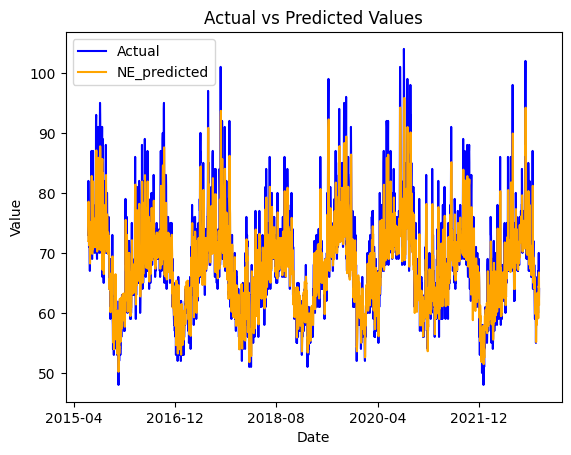

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.plot(df_test_dates,y_test, color="blue", label="Actual")
plt.plot(df_test_dates,yhat_ne, color="orange", label="NE_predicted")
# plt.plot(df_test_dates,yhat_svd, color="green", name="SVD_predicted")
# plt.plot(df_test_dates,yhat_skl, color="red", name="sklearn_predicted")

plt.title("Actual vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

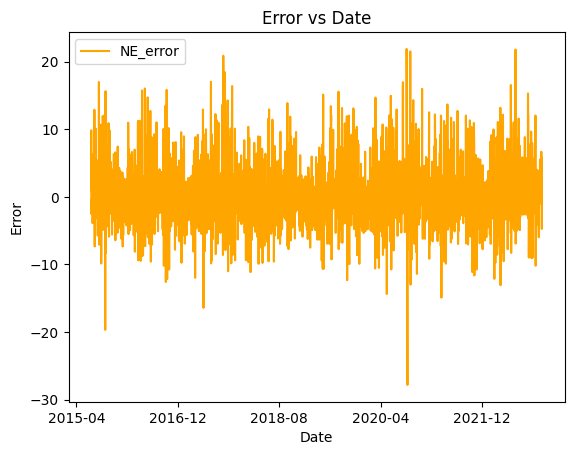

In [ ]:
error_ne = y_test - yhat_ne
error_svd = y_test - yhat_svd
error_skl = y_test - yhat_skl

plt.plot(df_test_dates,error_ne, color="orange", label="NE_error")
# plt.plot(df_test_dates,error_svd, color="green", label="SVD_error")
# plt.plot(df_test_dates,error_skl, color="red", label="sklearn_error")

plt.title("Error vs Date")
plt.xlabel("Date")
plt.ylabel("Error")
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

Mean Error (Bias): 0.641
Standard Deviation of Error: 4.653


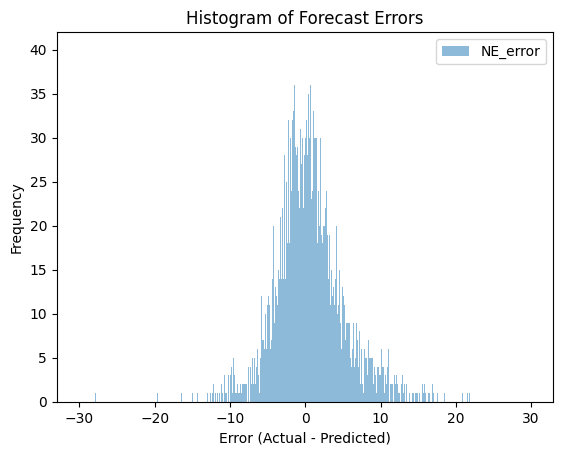

In [ ]:
import numpy as np

mean_error = np.mean(error_ne)
std_error = np.std(error_ne)

print(f"Mean Error (Bias): {mean_error:.3f}")
print(f"Standard Deviation of Error: {std_error:.3f}")

bins = np.arange(-30,30,0.1)
plt.hist(error_ne, bins, alpha=0.5, label='NE_error', )
plt.legend()
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Forecast Errors")
plt.show();

# Add Lag features

In [ ]:
df.index

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       321, 322, 323, 324, 325, 326, 327, 328, 329, 330],
      dtype='int32', length=13498)

In [ ]:
df['tmax_sma30'] = df['tmax'].rolling(window=30, min_periods=1).mean().round(1)



df.head()

,tmax,tmin,rain,tmax_tomorrow,tmax_sma3,tmax_sma30
1970-01-01,60.0,35.0,0.0,52.0,60.0,60.0
1970-01-02,52.0,39.0,0.0,52.0,56.0,56.0
1970-01-03,52.0,35.0,0.0,53.0,54.7,54.7
1970-01-04,53.0,36.0,0.0,52.0,54.2,54.2
1970-01-05,52.0,35.0,0.0,50.0,53.8,53.8


In [ ]:
feature_cols=("tmax", "tmin", "rain","tmax_sma30")
X = design_matrix(df, feature_cols=feature_cols)
y = target_vector(df, target_col="tmax_tomorrow")

n = len(df)
split = int(0.8*n)
X_train,X_test = X[:split], X[split:]
y_train,y_test = y[:split], y[split:]

df_test_dates = df.index[split:]
df_test_dates = pd.to_datetime(df_test_dates)

X_train.shape, X_test.shape, y_train.shape, y_test.shape,df_test_dates[0]

w_ne = ols_normal_eq(X_train, y_train)
w_svd = ols_svd(X_train, y_train)

yhat_ne = X_test @ w_ne
yhat_svd = X_test @ w_svd

# Sanity check compare scikit-learn
lin = LinearRegression(fit_intercept=False)
lin.fit(X_train, y_train)
yhat_skl = lin.predict(X_test)
print("Weights format: [intercept, tmax, tmin, rain, tmax_sma30]\n")
print("Normal Eq w:", w_ne)
print("SVD       w:", w_svd)
print("sklearn   w:", np.r_[lin.coef_])  # same format (intercept is column 0)

print()
evaluate("Normal Eq", y_test, yhat_ne)
evaluate("SVD",       y_test, yhat_svd)
evaluate("sklearn",   y_test, yhat_skl)

Weights format: [intercept, tmax, tmin, rain, tmax_sma30]

Normal Eq w: [ 4.31268895  0.64132704  0.09893937 -1.58259841  0.21809433]
SVD       w: [ 4.31268895  0.64132704  0.09893937 -1.58259841  0.21809433]
sklearn   w: [ 4.31268895  0.64132704  0.09893937 -1.58259841  0.21809433]

   Normal Eq | RMSE: 4.5809 | R^2: 0.6982
         SVD | RMSE: 4.5809 | R^2: 0.6982
     sklearn | RMSE: 4.5809 | R^2: 0.6982


# Apply fourier features

In [ ]:
index_date = df.index
index_day = pd.to_datetime(index_date).dayofyear
df["day_of_year"] = index_day
df['sin_doy'] = np.sin(2*np.pi*df['day_of_year']/365)
df['cos_doy'] = np.cos(2*np.pi*df['day_of_year']/365)

df.head()

,tmax,tmin,rain,tmax_tomorrow,tmax_sma3,tmax_sma30,day_of_year,sin_doy,cos_doy
1970-01-01,60.0,35.0,0.0,52.0,60.0,60.0,1,0.017213,0.999852
1970-01-02,52.0,39.0,0.0,52.0,56.0,56.0,2,0.034422,0.999407
1970-01-03,52.0,35.0,0.0,53.0,54.7,54.7,3,0.051620,0.998667
1970-01-04,53.0,36.0,0.0,52.0,54.2,54.2,4,0.068802,0.997630
1970-01-05,52.0,35.0,0.0,50.0,53.8,53.8,5,0.085965,0.996298


In [ ]:
feature_cols = ("tmax", "tmin", "rain","tmax_sma30", "sin_doy", "cos_doy")
X = design_matrix(df, feature_cols=feature_cols)
y = target_vector(df, target_col="tmax_tomorrow")

n = len(df)
split = int(0.8*n)
X_train,X_test = X[:split], X[split:]
y_train,y_test = y[:split], y[split:]

df_test_dates = df.index[split:]
df_test_dates = pd.to_datetime(df_test_dates)

X_train.shape, X_test.shape, y_train.shape, y_test.shape,df_test_dates[0]

w_ne = ols_normal_eq(X_train, y_train)
w_svd = ols_svd(X_train, y_train)

yhat_ne = X_test @ w_ne
yhat_svd = X_test @ w_svd

# Sanity check compare scikit-learn
lin = LinearRegression(fit_intercept=False)
lin.fit(X_train, y_train)
yhat_skl = lin.predict(X_test)
print("Weights format: [intercept, tmax, tmin, rain, tmax_sma30, sin_doy, cos_doy]\n")
print("Normal Eq w:", w_ne)
print("SVD       w:", w_svd)
print("sklearn   w:", np.r_[lin.coef_])  # same format (intercept is column 0)

print()
evaluate("Normal Eq", y_test, yhat_ne)
evaluate("SVD",       y_test, yhat_svd)
evaluate("sklearn",   y_test, yhat_skl)

Weights format: [intercept, tmax, tmin, rain, tmax_sma30, sin_doy, cos_doy]

Normal Eq w: [11.45659527  0.63191776  0.04156502 -0.91283358  0.16197376 -0.24328695
 -1.30512812]
SVD       w: [11.45659527  0.63191776  0.04156502 -0.91283358  0.16197376 -0.24328695
 -1.30512812]
sklearn   w: [11.45659527  0.63191776  0.04156502 -0.91283358  0.16197376 -0.24328695
 -1.30512812]

   Normal Eq | RMSE: 4.5669 | R^2: 0.7001
         SVD | RMSE: 4.5669 | R^2: 0.7001
     sklearn | RMSE: 4.5669 | R^2: 0.7001
